<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Flash-Test-Data" data-toc-modified-id="Import-Flash-Test-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Flash Test Data</a></span></li><li><span><a href="#Power-Tolerance-&amp;-Flash-Test-Function" data-toc-modified-id="Power-Tolerance-&amp;-Flash-Test-Function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Power Tolerance &amp; Flash Test Function</a></span></li><li><span><a href="#Power-Tolerance-&amp;-Mismatch:-310W-Arrays" data-toc-modified-id="Power-Tolerance-&amp;-Mismatch:-310W-Arrays-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Power Tolerance &amp; Mismatch: 310W Arrays</a></span></li><li><span><a href="#Power-Tolerance-&amp;-Mismatch:-315W-Arrays" data-toc-modified-id="Power-Tolerance-&amp;-Mismatch:-315W-Arrays-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Power Tolerance &amp; Mismatch: 315W Arrays</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Import Flash Test Data

In [2]:
flash_test_data = pd.read_excel("flash test data.xlsx")

In [3]:
flash_test_data.rename(columns={'Pmax':'Pmax(W)',
                                'voc':'Voc(V)',
                                'isc':'Isc(A)',
                                'vmax':'Vmp(V)',
                                'imax':'Imp(A)'},
                       inplace=True)

In [4]:
flash_test_data.head()

,Module_SerialNumber,Bin,Pmax(W),Voc(V),Isc(A),Vmp(V),Imp(A)
0,6150908100005,310,314.5239,45.61639,8.960044,37.04138,8.491151
1,6150908100010,310,313.7868,45.63112,8.952348,37.05749,8.467569
2,6150908100021,310,313.4251,45.59410,8.943293,37.01952,8.466483
3,6150908100076,310,314.1611,45.66395,8.953041,37.11833,8.463772
4,6150908100081,310,313.5674,45.59018,8.937472,36.99206,8.476612


In [5]:
flash_test_data.describe()

,Bin,Pmax(W),Voc(V),Isc(A),Vmp(V),Imp(A)
count,54990.000000,54990.000000,54990.000000,54990.000000,54990.000000,54990.000000
mean,312.099291,315.977412,40.888579,9.065091,36.850535,8.574801
std,2.467700,2.916329,12.117331,0.094101,0.256785,0.081239
min,310.000000,310.000400,8.800000,8.800000,35.981620,8.110000
25%,310.000000,313.990000,45.290892,8.987148,36.663332,8.512341
50%,310.000000,315.656877,45.453345,9.040000,36.842529,8.564947
75%,315.000000,317.517209,45.594098,9.145597,37.026689,8.635217
max,315.000000,327.981452,47.028190,9.399280,39.350000,8.883600


# Power Tolerance & Flash Test Function

In [6]:
# Function to randomly select x number modules per string and calculate power tolerance and mismatch
def power_tolerance_and_mismatch(flash_test_data, num_strings_in_plant, modules_per_string, Pmax):
    
    # Placeholders
    string_sample = []
    
    ### String mismatch losses ###
    # Calculate & record Imp and Isc mismatch for 'i' iterations (number of strings)
    for i in range(num_strings_in_plant):
        
        # Sample out a (random) string
        string_sample = flash_test_data.sample(n=modules_per_string).describe()
        
        # Record minimum and mean Imp
        Imp_min = string_sample.loc['min','Imp(A)']
        Imp_avg = string_sample.loc['mean','Imp(A)']
        mismatch_Imp = (Imp_min - Imp_avg) / Imp_avg
        
        # Record minimum and mean Isc
        Isc_min = string_sample.loc['min','Isc(A)']
        Isc_avg = string_sample.loc['mean','Isc(A)']      
        mismatch_Isc = (Isc_min - Isc_avg) / Isc_avg
        
        # Save sample output into dataframe
        new_string = pd.DataFrame(data=[[Imp_min, Imp_avg, mismatch_Imp, Isc_min, Isc_avg, mismatch_Isc]],
                                  columns=['Imp_min','Imp_avg','Mismatch_Imp','Isc_min','Isc_avg','Mismatch_Isc'])
        if i==0:
            plant_strings=new_string
        else:
            plant_strings= pd.concat([plant_strings,new_string],ignore_index=True)
    
    ### Overal plant mismatch losses ###
    # Calculate average mismatch loss from all sampled iterations
    average_module_Isc = flash_test_data.describe().loc['mean','Isc(A)']
    average_module_Imp = flash_test_data.describe().loc['mean','Imp(A)']
    average_string_Isc = np.mean(plant_strings['Isc_min'])
    average_string_Imp = np.mean(plant_strings['Imp_min'])
    mismatch_Imp = (average_string_Imp - average_module_Imp) / average_module_Imp
    print("Mismatch based on Imp: ")
    print(str(round(-mismatch_Imp*100,4))+"%")
    
    ### Power tolerance losses ###
    power_tolerance = np.mean((flash_test_data['Pmax(W)']-Pmax)/Pmax)
    print("Power Tolerance based on P Max: ")
    print(str(round(-power_tolerance*100,4))+"%")
    
    ### Combined power tolerance & mismatch losses ###
    combined_losses = ( (1 + power_tolerance) * (1 + mismatch_Imp) ) - 1 
    print("Combined power tolerance and mismatch: ")
    print(str(round(-combined_losses*100,4))+"%")
    
    ### Other calculation info ###
    print("\nMismatch losses:")
    std_mismatch_loss = np.std(plant_strings['Mismatch_Imp'])
    print("STD: " + str(round(std_mismatch_loss,4)))
    
    max_mismatch_loss = np.max(plant_strings['Mismatch_Imp'])
    print("Max: " + str(round(max_mismatch_loss * 100,4)) +"%")
    
    min_mismatch_loss = np.min(plant_strings['Mismatch_Imp'])
    print("Min: " + str(round(min_mismatch_loss * 100,4)) +"%")
    
    uncertainty = std_mismatch_loss / (1 - mismatch_Imp) 
    print("Uncertainty: "+ str(round(uncertainty * 100,4)) +"%")
     
    ### Graphs ###
    fig = plt.figure(1, (15,7))
    plt.plot(plant_strings['Mismatch_Imp']*100, label="Imp based")
    plt.plot(plant_strings['Mismatch_Isc']*100, label="Isc based")
    plt.xlabel('Iteration')
    plt.ylabel('Mismatch')
    plt.title('Mismatch Losses / Iterations')
    plt.legend()


# Power Tolerance & Mismatch: 310W Arrays

In [7]:
# The bins refer to the module's wattage
data_310W_modules = flash_test_data.loc[flash_test_data['Bin'] == 310]

In [8]:
# Calculate number of strings in plant
num_310W_modules = len(data_310W_modules)

In [9]:
# 315W module & array parameters from datasheet and plant configuration
Pmax= 310 # For Power tolerance comparison
Isc =  8.85 #[A] For reference
Voc = 45.50 #[V] For reference
Imp =  8.38 #[A] For reference
Vmp = 37.00 #[V] For reference
num_modules_per_string = 20 # Number of modules connected together to form a string
num_strings_in_plant = int(num_310W_modules/num_modules_per_string) # Number of strings over the plant

Mismatch based on Imp: 
1.5074%
Power Tolerance based on P Max: 
-1.6312%
Combined power tolerance and mismatch: 
-0.0992%

Mismatch losses:
STD: 0.0031
Max: -0.6658%
Min: -2.6578%
Uncertainty: 0.3067%


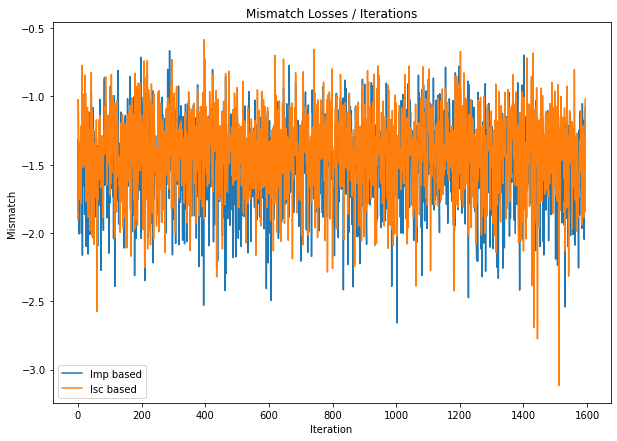

In [10]:
# Running mismatch & power tolerance function
power_tolerance_and_mismatch(data_310W_modules, 
                             num_strings_in_plant,
                             num_modules_per_string,
                             Pmax)

# Power Tolerance & Mismatch: 315W Arrays

In [11]:
data_315W_modules = flash_test_data.loc[flash_test_data['Bin'] == 315]

In [12]:
# Calculate number of strings in plant
num_315W_modules = len(data_315W_modules)

In [13]:
# 315W module & array parameters from datasheet and plant configuration
Pmax= 315 # For Power tolerance comparison
Isc =  9.00 #[A]For reference
Voc = 45.60 #[V]For reference
Imp =  8.51 #[A]For reference
Vmp = 37.10 #[V]For reference
num_modules_per_string = 20 # Number of modules connected together to form a string
num_strings_in_plant = int(num_315W_modules/num_modules_per_string) # Number of strings over the plant

Mismatch based on Imp: 
1.3851%
Power Tolerance based on P Max: 
-0.7141%
Combined power tolerance and mismatch: 
0.6808%

Mismatch losses:
STD: 0.0029
Max: -0.6763%
Min: -3.6693%
Uncertainty: 0.2887%


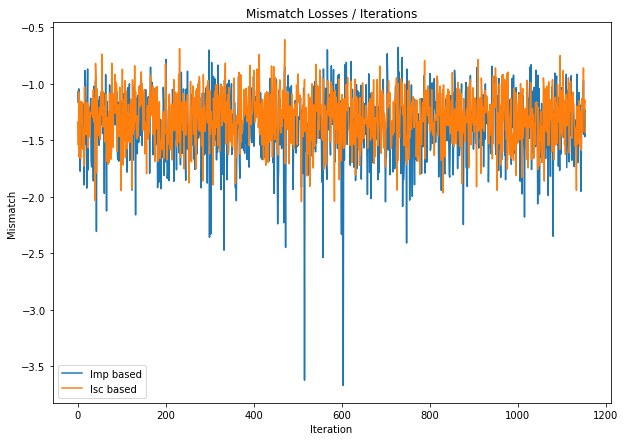

In [14]:
# Running mismatch & power tolerance function
power_tolerance_and_mismatch(data_315W_modules, 
                             num_strings_in_plant,
                             num_modules_per_string,
                             Pmax)